In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
from geopy.distance import geodesic

ModuleNotFoundError: No module named 'torch'

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the data
df = pd.read_csv('/content/drive/My Drive/merged_dataset_latitude_longitudes.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Unnamed: 0.1', axis=1)
df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Latitude,Longitude
0,Albania,Maize,1990,36613,1485.0,121.00,16.37,5.758765,-73.915162
1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37,5.758765,-73.915162
2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37,5.758765,-73.915162
3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37,5.758765,-73.915162
4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37,5.758765,-73.915162
...,...,...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76,-18.455496,29.746841
28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76,-18.455496,29.746841
28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76,-18.455496,29.746841
28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76,-18.455496,29.746841


In [ ]:
# Sort data by Area date Item
df = df.sort_values(by=['Item','Area','Year'])
df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Latitude,Longitude
213,Angola,Cassava,1990,41177,1010.0,64.00,24.12,-11.877577,17.569124
219,Angola,Cassava,1991,40295,1010.0,79.00,24.02,-11.877577,17.569124
225,Angola,Cassava,1992,42295,1010.0,23.00,23.96,-11.877577,17.569124
231,Angola,Cassava,1993,42295,1010.0,169.00,24.15,-11.877577,17.569124
237,Angola,Cassava,1994,58596,1010.0,25.50,24.04,-11.877577,17.569124
...,...,...,...,...,...,...,...,...,...
24148,Rwanda,Yams,2013,154700,1212.0,1841.50,19.93,-1.964663,30.064436
25878,Sudan,Yams,2012,19737,1712.0,2469.47,26.42,34.067864,-102.524362
25879,Sudan,Yams,2012,19737,1712.0,2469.47,29.96,34.067864,-102.524362
25892,Sudan,Yams,2013,21053,1712.0,2469.47,26.84,34.067864,-102.524362


In [ ]:
# Normalize only the yield Price column
scaler = StandardScaler()
df['hg/ha_yield'] = scaler.fit_transform(df[['hg/ha_yield']])

In [ ]:
df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Latitude,Longitude
213,Angola,Cassava,1990,-0.422298,1010.0,64.00,24.12,-11.877577,17.569124
219,Angola,Cassava,1991,-0.432679,1010.0,79.00,24.02,-11.877577,17.569124
225,Angola,Cassava,1992,-0.409138,1010.0,23.00,23.96,-11.877577,17.569124
231,Angola,Cassava,1993,-0.409138,1010.0,169.00,24.15,-11.877577,17.569124
237,Angola,Cassava,1994,-0.217260,1010.0,25.50,24.04,-11.877577,17.569124
...,...,...,...,...,...,...,...,...,...
24148,Rwanda,Yams,2013,0.913973,1212.0,1841.50,19.93,-1.964663,30.064436
25878,Sudan,Yams,2012,-0.674666,1712.0,2469.47,26.42,34.067864,-102.524362
25879,Sudan,Yams,2012,-0.674666,1712.0,2469.47,29.96,34.067864,-102.524362
25892,Sudan,Yams,2013,-0.659176,1712.0,2469.47,26.84,34.067864,-102.524362


In [ ]:
# Create lag features for the modal price for 7 years
time_horizon = 7
for lag in range(1, time_horizon + 1):
    df[f'yield_lag_{lag}'] = df['hg/ha_yield'].shift(lag)

In [ ]:
df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Latitude,Longitude,yield_lag_1,yield_lag_2,yield_lag_3,yield_lag_4,yield_lag_5,yield_lag_6,yield_lag_7
213,Angola,Cassava,1990,-0.422298,1010.0,64.00,24.12,-11.877577,17.569124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,Angola,Cassava,1991,-0.432679,1010.0,79.00,24.02,-11.877577,17.569124,-0.422298,NaN,NaN,NaN,NaN,NaN,NaN
225,Angola,Cassava,1992,-0.409138,1010.0,23.00,23.96,-11.877577,17.569124,-0.432679,-0.422298,NaN,NaN,NaN,NaN,NaN
231,Angola,Cassava,1993,-0.409138,1010.0,169.00,24.15,-11.877577,17.569124,-0.409138,-0.432679,-0.422298,NaN,NaN,NaN,NaN
237,Angola,Cassava,1994,-0.217260,1010.0,25.50,24.04,-11.877577,17.569124,-0.409138,-0.409138,-0.432679,-0.422298,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24148,Rwanda,Yams,2013,0.913973,1212.0,1841.50,19.93,-1.964663,30.064436,0.005234,-0.121197,-0.065097,-0.294889,-0.367680,-0.341749,-0.325282
25878,Sudan,Yams,2012,-0.674666,1712.0,2469.47,26.42,34.067864,-102.524362,0.913973,0.005234,-0.121197,-0.065097,-0.294889,-0.367680,-0.341749
25879,Sudan,Yams,2012,-0.674666,1712.0,2469.47,29.96,34.067864,-102.524362,-0.674666,0.913973,0.005234,-0.121197,-0.065097,-0.294889,-0.367680
25892,Sudan,Yams,2013,-0.659176,1712.0,2469.47,26.84,34.067864,-102.524362,-0.674666,-0.674666,0.913973,0.005234,-0.121197,-0.065097,-0.294889


In [ ]:
# Drop NaN values created by lag features
df = df.dropna()

In [ ]:
# Encode categorical features
label_encoder = LabelEncoder()
df['Area'] = label_encoder.fit_transform(df['Area'])
df['Item'] = label_encoder.fit_transform(df['Item'])

<ipython-input-11-bc4fcecfc872>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Area'] = label_encoder.fit_transform(df['Area'])
<ipython-input-11-bc4fcecfc872>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Item'] = label_encoder.fit_transform(df['Item'])


In [ ]:
# Prepare time series data for LSTM with 7-year lag
X_time_series = df[['Year','Item','average_rain_fall_mm_per_year','pesticides_tonnes','avg_temp']+[f'yield_lag_{i}' for i in range(1, time_horizon + 1)]].values.reshape(-1, time_horizon+5, 1)
#X_time_series = df[['Year','average_rain_fall_mm_per_year','pesticides_tonnes','avg_temp']].values
y = df['hg/ha_yield'].values

In [ ]:
locations = df['Area'].unique()
locations

array([  2,   3,   8,  14,  16,  17,  18,  20,  22,  25,  26,  28,  34,
        36,  37,  38,  39,  40,  42,  43,  47,  50,  56,  57,  58,  59,
        61,  62,  65,  70,  71,  74,  75,  80,  82,  86,  88,  92,  95,
        99, 100,   0,   1,   4,   5,   6,   7,  10,  11,  12,  13,  15,
        19,  21,  23,  24,  27,  29,  32,  33,  35,  41,  44,  46,  48,
        49,  52,  53,  54,  55,  60,  63,  64,  66,  67,  68,  69,  73,
        76,  77,  78,  79,  81,  83,  84,  85,  87,  90,  91,  94,  96,
        98,   9,  30,  31,  45,  51,  72,  89,  93,  97])

In [ ]:
df2 = df[['Area', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
df2

,Area,Latitude,Longitude
0,2,-11.877577,17.569124
1,3,-34.996496,-64.967282
2,8,24.773655,-78.000055
3,14,-10.333333,-53.200000
4,16,12.075308,-1.688031
...,...,...,...
96,51,56.840649,24.753764
97,72,64.573154,11.528036
98,89,59.674971,14.520858
99,93,36.800207,10.185776


In [ ]:
import math
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate distance between two points given their latitudes and longitudes
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

Streaming output truncated to the last 5000 lines.
51 0
51 1
51 2
51 3
51 4
51 5
51 6
51 7
51 8
51 9
51 10
51 11
51 12
51 13
51 14
51 15
51 16
51 17
51 18
51 19
51 20
51 21
51 22
51 23
51 24
51 25
51 26
51 27
51 28
51 29
51 30
51 31
51 32
51 33
51 34
51 35
51 36
51 37
51 38
51 39
51 40
51 41
51 42
51 43
51 44
51 45
51 46
51 47
51 48
51 49
51 50
51 52
51 53
51 54
51 55
51 56
51 57
51 58
51 59
51 60
51 61
51 62
51 63
51 64
51 65
51 66
51 67
51 68
51 69
51 70
51 71
51 72
51 73
51 74
51 75
51 76
51 77
51 78
51 79
51 80
51 81
51 82
51 83
51 84
51 85
51 86
51 87
51 88
51 89
51 90
51 91
51 92
51 93
51 94
51 95
51 96
51 97
51 98
51 99
51 100
52 0
52 1
52 2
52 3
52 4
52 5
52 6
52 7
52 8
52 9
52 10
52 11
52 12
52 13
52 14
52 15
52 16
52 17
52 18
52 19
52 20
52 21
52 22
52 23
52 24
52 25
52 26
52 27
52 28
52 29
52 30
52 31
52 32
52 33
52 34
52 35
52 36
52 37
52 38
52 39
52 40
52 41
52 42
52 43
52 44
52 45
52 46
52 47
52 48
52 49
52 50
52 51
52 53
52 54
52 55
52 56
52 57
52 58
52 59
52 60
52 61
52

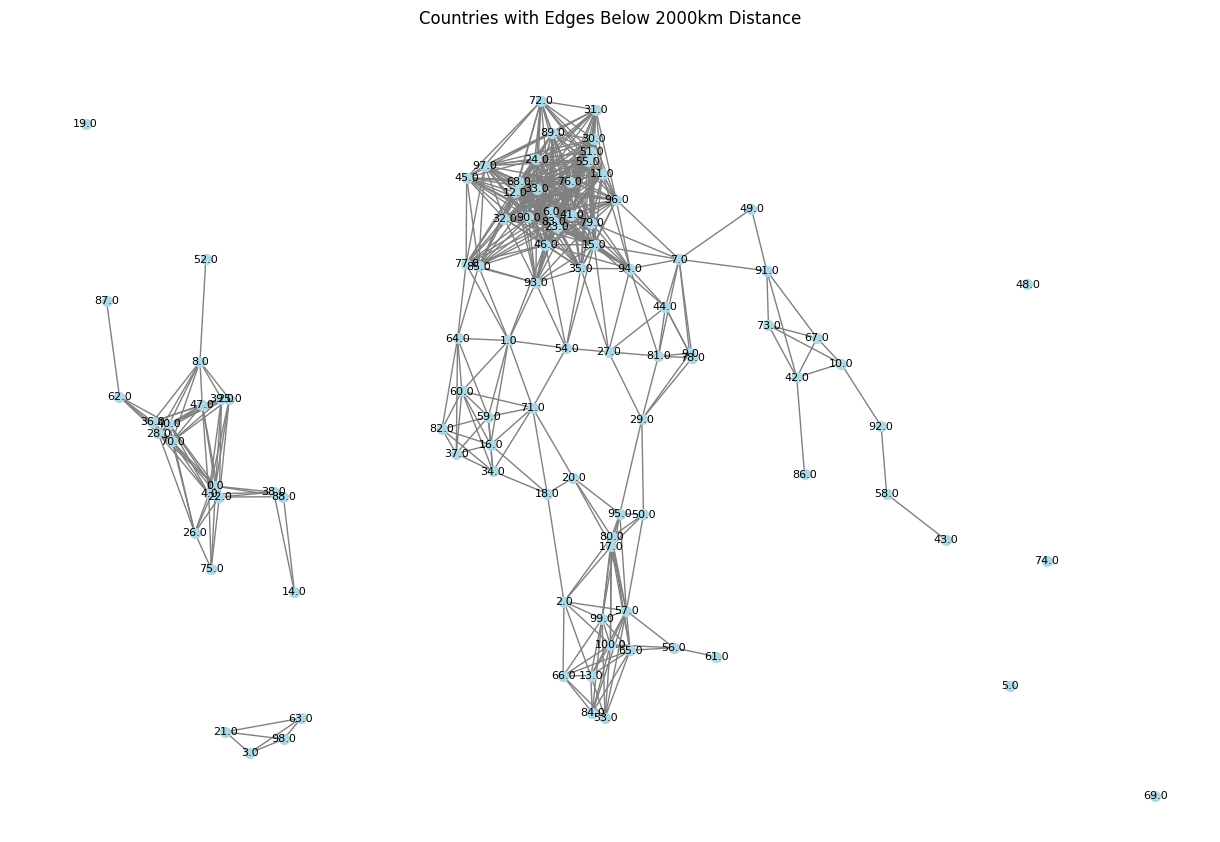

In [ ]:
# Create a graph
G = nx.Graph()

# Add nodes with positions (latitudes and longitudes)
for _, row in df2.iterrows():
    G.add_node(row['Area'], pos=(row['Longitude'], row['Latitude']))

# Add edges for markets within 2000 km
for i, row1 in df2.iterrows():
    for j, row2 in df2.iterrows():
        if i != j:
            print(str(i)+" "+str(j))
            distance = haversine(row1['Latitude'], row1['Longitude'], row2['Latitude'], row2['Longitude'])
            if distance <= 2000:
                G.add_edge(row1['Area'], row2['Area'])

# Extract positions for plotting
positions = nx.get_node_attributes(G, 'pos')

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    #labels={row['Locations']: f"{row['Locations']}\n({row['Latitude']:.2f}, {row['Longitude']:.2f})" for _, row in market_locations.iterrows()},
    node_color='lightblue',
    node_size=50,
    font_size=8,
    edge_color='gray'
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Countries with Edges Below 2000km Distance")
plt.grid(True)
plt.show()

In [ ]:
# Prepare geospatial data for GraphSAGE
countries = df[['Area', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
country_indices = {country: i for i, country in enumerate(countries['Area'])}
country_indices

{2: 0,
 3: 1,
 8: 2,
 14: 3,
 16: 4,
 17: 5,
 18: 6,
 20: 7,
 22: 8,
 25: 9,
 26: 10,
 28: 11,
 34: 12,
 36: 13,
 37: 14,
 38: 15,
 39: 16,
 40: 17,
 42: 18,
 43: 19,
 47: 20,
 50: 21,
 56: 22,
 57: 23,
 58: 24,
 59: 25,
 61: 26,
 62: 27,
 65: 28,
 70: 29,
 71: 30,
 74: 31,
 75: 32,
 80: 33,
 82: 34,
 86: 35,
 88: 36,
 92: 37,
 95: 38,
 99: 39,
 100: 40,
 0: 41,
 1: 42,
 4: 43,
 5: 44,
 6: 45,
 7: 46,
 10: 47,
 11: 48,
 12: 49,
 13: 50,
 15: 51,
 19: 52,
 21: 53,
 23: 54,
 24: 55,
 27: 56,
 29: 57,
 32: 58,
 33: 59,
 35: 60,
 41: 61,
 44: 62,
 46: 63,
 48: 64,
 49: 65,
 52: 66,
 53: 67,
 54: 68,
 55: 69,
 60: 70,
 63: 71,
 64: 72,
 66: 73,
 67: 74,
 68: 75,
 69: 76,
 73: 77,
 76: 78,
 77: 79,
 78: 80,
 79: 81,
 81: 82,
 83: 83,
 84: 84,
 85: 85,
 87: 86,
 90: 87,
 91: 88,
 94: 89,
 96: 90,
 98: 91,
 9: 92,
 30: 93,
 31: 94,
 45: 95,
 51: 96,
 72: 97,
 89: 98,
 93: 99,
 97: 100}

In [ ]:
# Calculate pairwise distances and create adjacency matrix
distances = np.zeros((len(countries), len(countries)))
for i, row_i in countries.iterrows():
    for j, row_j in countries.iterrows():
        if i != j:
            distances[i, j] = geodesic((row_i['Latitude'], row_i['Longitude']), (row_j['Latitude'], row_j['Longitude'])).km

In [ ]:
# Create edge index based on a threshold distance
threshold_distance = 2000  # Example threshold distance in km
edge_index = np.array([[i, j] for i in range(len(countries)) for j in range(len(countries)) if distances[i, j] < threshold_distance]).T
edge_index = torch.tensor(edge_index, dtype=torch.long)

In [ ]:
# Create geospatial features tensor
x_geospatial = torch.tensor(countries[['Latitude', 'Longitude']].values, dtype=torch.float)

# Create time series training and validation sets
X_time_series_train, X_time_series_val, y_train, y_val = train_test_split(X_time_series, y, test_size=0.2, random_state=42)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import Data

In [ ]:
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim, aggr='mean')  # Using mean aggregation
        self.conv2 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x


In [ ]:
# Define LSTM model with updated input_dim for 30 days time horizon
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        h, _ = self.lstm(x)
        h = h[:, -1, :]
        out = self.fc(h)
        return out

In [ ]:
country_indices = torch.tensor(df["Area"].values, dtype=torch.long)


In [ ]:
area_to_index = {area: idx for idx, area in enumerate(df["Area"].unique())}
country_indices = torch.tensor([area_to_index[area] for area in df["Area"]], dtype=torch.long)


In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, graphsage, lstm, hidden_dim, output_dim):
        super(CombinedModel, self).__init__()
        self.graphsage = graphsage  # GraphSAGE
        self.lstm = lstm
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_time_series, x_geospatial, edge_index, country_indices):
        # GraphSAGE Forward
        graphsage_out = self.graphsage(x_geospatial, edge_index)

        # Ensure country_indices contains valid integer indices
        graphsage_out = graphsage_out[country_indices]  # Map GraphSAGE embeddings to time-series rows

        # LSTM Forward
        lstm_out = self.lstm(x_time_series)

        # Ensure graph_out and lstm_out have the same number of rows
        batch_size = lstm_out.shape[0]
        graphsage_out = graphsage_out[:batch_size]  # Adjust to match batch size

        # Combine outputs
        combined = torch.cat([graphsage_out, lstm_out], dim=1)
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        return x


# Initialize models
input_dim_graphsage = x_geospatial.size(1)
hidden_dim = 32
output_dim = 1

graphsage = GraphSAGE(input_dim_graphsage, hidden_dim)  # Using GraphSAGE here
lstm = LSTMModel(1, hidden_dim, hidden_dim)
model = CombinedModel(graphsage, lstm, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Convert data to PyTorch tensors
X_time_series_train = torch.tensor(X_time_series_train, dtype=torch.float)
X_time_series_val = torch.tensor(X_time_series_val, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float).view(-1, 1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_time_series_train, x_geospatial, edge_index, country_indices)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")


<ipython-input-30-d25966ba4c34>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_time_series_train = torch.tensor(X_time_series_train, dtype=torch.float)
<ipython-input-30-d25966ba4c34>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_time_series_val = torch.tensor(X_time_series_val, dtype=torch.float)
<ipython-input-30-d25966ba4c34>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
<ipython-input-30-d25966ba4c34>:47: UserWarning: To copy construct from a tensor, it is r

Epoch [1/1000], Loss: 2.7015
Epoch [2/1000], Loss: 28467.2168
Epoch [3/1000], Loss: 575.2747
Epoch [4/1000], Loss: 50348.4062
Epoch [5/1000], Loss: 1393.3323
Epoch [6/1000], Loss: 2734.3086
Epoch [7/1000], Loss: 390.0550
Epoch [8/1000], Loss: 36.2088
Epoch [9/1000], Loss: 29.2961
Epoch [10/1000], Loss: 6.4139
Epoch [11/1000], Loss: 4.3046
Epoch [12/1000], Loss: 6.3275
Epoch [13/1000], Loss: 7.3795
Epoch [14/1000], Loss: 4.8259
Epoch [15/1000], Loss: 1.3117
Epoch [16/1000], Loss: 5.1123
Epoch [17/1000], Loss: 3.3236
Epoch [18/1000], Loss: 1.5478
Epoch [19/1000], Loss: 5.4031
Epoch [20/1000], Loss: 3.5001
Epoch [21/1000], Loss: 0.9607
Epoch [22/1000], Loss: 4.2349
Epoch [23/1000], Loss: 1.4980
Epoch [24/1000], Loss: 1.5622
Epoch [25/1000], Loss: 3.2830
Epoch [26/1000], Loss: 0.5058
Epoch [27/1000], Loss: 1.8965
Epoch [28/1000], Loss: 1.6780
Epoch [29/1000], Loss: 0.3317
Epoch [30/1000], Loss: 2.0808
Epoch [31/1000], Loss: 0.4684
Epoch [32/1000], Loss: 1.0641
Epoch [33/1000], Loss: 1.2717

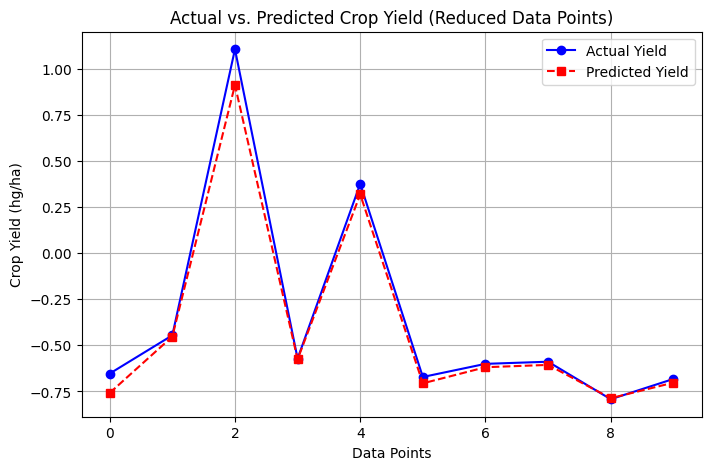

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Set the model to evaluation mode
model.eval()

# Generate predictions
with torch.no_grad():
    y_predicted = model(X_time_series_val, x_geospatial, edge_index, country_indices)

# Convert tensors to numpy arrays for plotting
y_actual_np = y_val.cpu().numpy().flatten()  # Actual values
y_predicted_np = y_predicted.cpu().numpy().flatten()  # Predicted values

# Select only 10 evenly spaced data points
num_points = 10  # Change this to reduce/increase further
indices = np.linspace(0, len(y_actual_np) - 1, num_points, dtype=int)

# Sample selected points
y_actual_sampled = y_actual_np[indices]
y_predicted_sampled = y_predicted_np[indices]
x_sampled = range(len(y_actual_sampled))

# Plot Actual vs. Predicted Crop Yield with reduced data points
plt.figure(figsize=(8, 5))
plt.plot(x_sampled, y_actual_sampled, marker='o', linestyle='-', label="Actual Yield", color='b')
plt.plot(x_sampled, y_predicted_sampled, marker='s', linestyle='--', label="Predicted Yield", color='r')

# Labels and Title
plt.xlabel("Data Points")
plt.ylabel("Crop Yield (hg/ha)")
plt.title("Actual vs. Predicted Crop Yield (Reduced Data Points)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    predicted_prices = model(X_time_series_val, x_geospatial, edge_index,country_indices)

# Compute metrics
test_mse = mean_squared_error(y_val.cpu().numpy(), predicted_prices.cpu().numpy())
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_val.cpu().numpy(), predicted_prices.cpu().numpy())
test_mape = mean_absolute_percentage_error(y_val.cpu().numpy(), predicted_prices.cpu().numpy())  # MAPE in percentage
test_r2 = r2_score(y_val.cpu().numpy(), predicted_prices.cpu().numpy())



print(f"Testing Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Testing Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Testing Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"Testing Mean Absolute Percentage Error (MAPE): {test_mape:.4f}%")
print(f"Testing R-squared (R2): {test_r2:.4f}")

Testing Mean Squared Error (MSE): 0.0461
Testing Root Mean Squared Error (RMSE): 0.2146
Testing Mean Absolute Error (MAE): 0.0880
Testing Mean Absolute Percentage Error (MAPE): 0.3968%
Testing R-squared (R2): 0.9529
